In [23]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

In [24]:
# Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
# Define the ticker symbol for Microsoft
ticker_symbol = 'MSFT'

# Define the historical date range for data retrieval
start_date = '1986-03-13'
end_date = '2024-10-14'

# Fetch the historical stock data from Yahoo Finance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Reset the DataFrame index and store the original index as a new column
# data = data.reset_index()

# Display the last few rows of the DataFrame
data.tail()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-10-07,416.000000,417.109985,409.000000,409.540009,409.540009,20919800
2024-10-08,410.899994,415.660004,408.170013,414.709991,414.709991,19229300
2024-10-09,415.859985,420.380005,414.299988,417.459991,417.459991,14974300
2024-10-10,415.230011,417.350006,413.149994,415.839996,415.839996,13848400
2024-10-11,416.140015,417.130005,413.250000,416.320007,416.320007,14126600


In [26]:
# Check if the index column 'Date' is in datetime64
data.index.inferred_type == "datetime64"

True

In [27]:
# Select only the index 'Date' and 'Close' columns from the DataFrame
data = data[['Close']]

# Display the first few rows of the simplified DataFrame
data.head()


,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


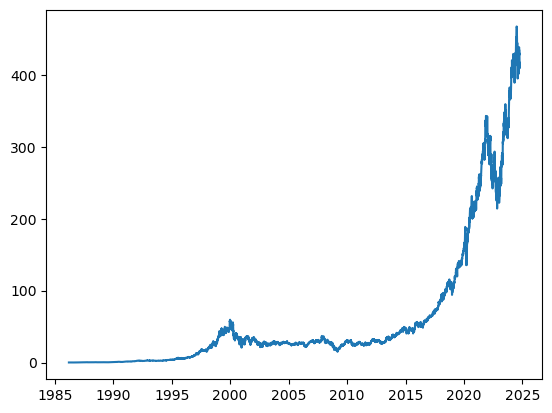

In [29]:
# Plot the data
plt.plot(data.index, data['Close'])